## Resnet model with 2 inputs: pose, image

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
BATCH_SIZE= 32
num_classes= 8

In [18]:
dict = {
     'Tesettür Elbise': [1, 0, 0, 0, 0, 0, 0, 0],
     'Tunik': [0, 1, 0, 0, 0, 0, 0, 0],
     'Şal':  [0, 0, 1, 0, 0, 0, 0, 0],
     'Eşarp': [0, 0, 0, 1, 0, 0, 0, 0],
     'Takım': [0, 0, 0, 0, 1, 0, 0, 0],
     "Kap / Pardesü":[0, 0, 0, 0, 0, 1, 0, 0],
     "Ferace":[0, 0, 0, 0, 0, 0, 1, 0],
     "T-shirt":[0, 0, 0, 0, 0, 0, 0, 1]
     }
#One hot encoding of labels

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, list_pose, batch_size= BATCH_SIZE, dim=(32,32,32), n_channels= 1, n_classes=8, shuffle= True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_pose = list_pose
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
    
    def __len__(self):
        return int(np.floor(len(self.list_pose) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_pose_temp = [self.list_pose[k] for k in indexes]

        i,p,l = self.__data_generation(list_pose_temp)
        return [i, p], l #image, pose, label

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_pose))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    def __data_generation(self, list_pose_temp):   
        X = np.empty((self.batch_size, 66,1))
        Z = np.empty((self.batch_size, 135,100, 3))
        l = np.empty((self.batch_size, num_classes))
        #X: poses   Z: Images   l: Labels   
        
        for i, each in enumerate(list_pose_temp):                
            X[i,] = np.reshape(np.load('C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/'+ str(each[1]) +".npy", allow_pickle=True),(66,1))
            image = Image.open('C:/Users/IDU/Desktop/dataset/'+ str( each[1] )+ ".jpg")
            image = np.array( (image.convert('RGB')).resize((100,135)) ) 
            
            Z[i,] = image / 255.0
            
            l[i] = dict[ each[2]]
            
        return Z,X,l
    

In [ ]:
params = {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': False}

out = pd.read_csv(r"C:\Users\IDU\OneDrive - GTÜ\Desktop\TEZ\poses\Master_Thesis_Plus\resnet-10classes\out1.csv")

poselist = out.to_numpy() #contains productid and labels


In [ ]:

# Generators
pose_generator = DataGenerator( poselist[:400], **params) #train generator
val_generator = DataGenerator( poselist[45000:], **params)

In [ ]:
df['category'].unique()

________
## test

In [ ]:
image =val_generator.__getitem__(0)[0][0][0]
plt.imshow(image)

In [ ]:
im= "1852141"

image = Image.open('C:/Users/IDU/Desktop/dataset/'+ im+ ".jpg")
image = np.array( (image.convert('RGB')).resize((100,135)) ) 
plt.imshow(image)

In [ ]:
pose = np.reshape(np.load('C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/'+ im +".npy", allow_pickle=True),(66,1))

_____

In [ ]:
input_shape=(135,100,3) #image input shape
pose_shape = (66,1)
pose_input = tf.keras.layers.Input(pose_shape)

model = ResNet50( include_top= False, input_shape= input_shape , classes= num_classes)

x = GlobalAveragePooling2D()(model.output)
x = Dense(256, activation ='relu')(x)
x = Dense(66, activation ='relu')(x)
x= tf.expand_dims(x, axis= -1)

concat = tf.concat([x, pose_input], axis=1 )
concat = Flatten()(concat)

x = tf.keras.layers.Dense(32, activation= 'relu')(concat)

y = tf.keras.layers.Dense(num_classes)(x)

model = tf.keras.models.Model(inputs= [model.input, pose_input] , outputs= y)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 2 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)


In [ ]:
model.compile( optimizer= "adam", loss='categorical_crossentropy', metrics= ['accuracy'] )

In [ ]:
history= model.fit(pose_generator, 
          batch_size= BATCH_SIZE,
          epochs= 5 , callbacks=[lr_scheduler])
#callbacks= [cp_callback]

In [ ]:
X = np.empty(( 1 , 66,1))
Z = np.empty(( 1, 135,100, 3))

each ="1619375.npy"
X[0,] =np.reshape(np.load('C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/'+ each ,allow_pickle=True),(66,1))
image = Image.open('C:/Users/IDU/Desktop/dataset/'+ each.split(".")[0] +".jpg")
image = np.array((image.convert('RGB')).resize((100, 135)))

Z[0,] = image / 255.0
plt.imshow(image)

In [ ]:
model.predict([np.array(Z),X])

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')
model.save_weights("C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/Master_Thesis_Plus/pretrained_weights_8class.h5")

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig('model_accuracy.png')
plt.show()


In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()


In [ ]:
model.save('model_poseResnet.h5')

In [ ]:
len(poselist)

# 3/8 class resnet

In [5]:
BATCH_SIZE= 8
num_classes= 8

In [32]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, list_pose, labeldf, batch_size= BATCH_SIZE, dim=(32,32,32), n_channels= 1,n_classes=3, shuffle= True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_pose = list_pose
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.labeldf =labeldf
        self.on_epoch_end()
        self.n = 0
    
    def __len__(self):
        
        return int(np.floor(len(self.list_pose) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_pose_temp = [self.list_pose[k] for k in indexes]

        i,p,l = self.__data_generation(list_pose_temp)
        #print("here", i.shape,p.shape,l.shape)
        return [i, p], l #image pose label

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_pose))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    def __data_generation(self, list_pose_temp):   
        X = np.empty((self.batch_size, 66,1))
        Z = np.empty((self.batch_size, 135,100, 3))
        l = np.empty((self.batch_size, self.n_classes ))
        
        for i, each in enumerate(list_pose_temp):          

            X[i,] =np.reshape(np.load('C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/'+ str(each[1])+".npy" ,allow_pickle=True),(66,1))
            image = Image.open('C:/Users/IDU/Desktop/dataset/'+ str(each[1]) +".jpg")
            image = np.array((image.convert('RGB')).resize((100, 135)))

            Z[i,] = image / 255.0
            label = self.labeldf['category'][self.labeldf['productid']== each[1]].values[0]
            l[i,] = dict[each[2]]      
            
        return Z,X,l
    


params = {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': 8,
          'n_channels': 1,""
          'shuffle': True}


df = pd.read_csv(r"C:\Users\IDU\OneDrive - GTÜ\Desktop\TEZ\MODANISA\prod_details.csv")



#print("debug",df['category'][df['productid']== int(8010707 )])

# Generators
pose_generator = DataGenerator(poselist[:4000],df, **params)
val_generator = DataGenerator(poselist[4001:4500],df, **params)

input_shape=(135,100,3)

pose_shape = (66,1)

model = ResNet50( include_top= False , input_shape= input_shape , classes= num_classes)


x = GlobalAveragePooling2D()(model.output)
x = Dense(256, activation ='relu')(x)
x = Dense(66, activation ='relu')(x)
x= tf.expand_dims(x, axis= -1)


pose_input = tf.keras.layers.Input(pose_shape)

concat = tf.concat([x, pose_input], axis=1 )
concat = Flatten()(concat)

#x = Dense(64, activation='relu')(concat)
x = tf.keras.layers.Dense(32, activation= 'relu')(concat)

y = tf.keras.layers.Dense(num_classes, activation= 'sigmoid')(x)


model = tf.keras.models.Model(inputs= [model.input, pose_input] , outputs= y)

model.compile( optimizer= "adam", loss='categorical_crossentropy', metrics= ['accuracy'] )


C:\Users\IDU\anaconda3\envs\tens_env\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (56,60,75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [33]:
history = model.fit( pose_generator, 
          batch_size = BATCH_SIZE,
          epochs= 40 )

Epoch 1/40
500/500 [==============================] - 1778s 4s/step - loss: 1.6839 - accuracy: 0.3347
Epoch 2/40
500/500 [==============================] - 1397s 3s/step - loss: 1.4071 - accuracy: 0.3618
Epoch 3/40
500/500 [==============================] - 1322s 3s/step - loss: 1.3424 - accuracy: 0.3672
Epoch 4/40
500/500 [==============================] - 1334s 3s/step - loss: 1.2280 - accuracy: 0.5288
Epoch 5/40
500/500 [==============================] - 1312s 3s/step - loss: 1.0561 - accuracy: 0.6438
Epoch 6/40
500/500 [==============================] - 1313s 3s/step - loss: 0.9676 - accuracy: 0.6722
Epoch 7/40
500/500 [==============================] - 1319s 3s/step - loss: 0.9046 - accuracy: 0.6873
Epoch 8/40
500/500 [==============================] - 1309s 3s/step - loss: 0.8577 - accuracy: 0.6960
Epoch 9/40
500/500 [==============================] - 1324s 3s/step - loss: 0.8174 - accuracy: 0.7067
Epoch 10/40
500/500 [==============================] - 1318s 3s/step - loss: 0.774

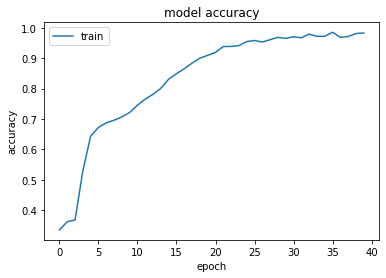

In [34]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig('model_accuracy.png')
plt.show()


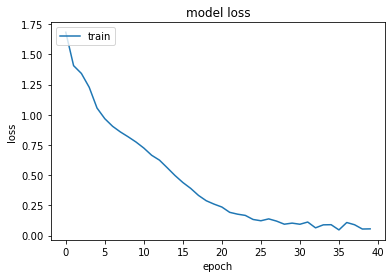

In [35]:

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()


In [37]:
model.save(r"C:\Users\IDU\OneDrive - GTÜ\Desktop\TEZ\poses\Master_Thesis_Plus\resnet-10classes\resnet8class_good.h5")

#  Evaluate 

In [65]:
val_params= {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': 8,
          'n_channels': 1,""
          'shuffle': False}

In [67]:
val_generator = DataGenerator(poselist[4001:4500],df, **val_params)

In [40]:
y_pred = model.predict(val_generator)

In [45]:
y_pred[0]

array([3.4692794e-02, 5.1610881e-01, 1.8743900e-06, 4.5970934e-09,
       5.1450431e-03, 2.6386976e-04, 4.9323397e-08, 5.2573882e-06],
      dtype=float32)

In [59]:
np.array(val_generator.__getitem__(0)[0][0]).shape

(8, 135, 100, 3)

In [63]:
(val_generator.__getitem__(0)[0][0][0]).shape

(135, 100, 3)

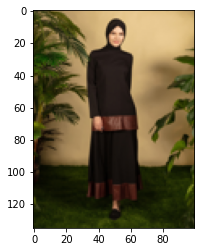

In [64]:
im =val_generator.__getitem__(0)[0][0][0]
plt.imshow(im)

In [66]:
poselist[0]

array([3, 1168509, 'Tunik'], dtype=object)

In [69]:
scores = model.evaluate(val_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))


62/62 [==============================] - 34s 541ms/step - loss: 1.7247 - accuracy: 0.6794
evaluate accuracy: 67.94%


# Predict

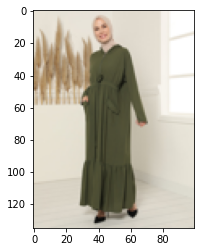

In [70]:
X = np.empty(( 1 , 66,1))
Z = np.empty(( 1, 135,100, 3))

each ="1619375.npy"
X[0,] =np.reshape(np.load('C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/'+ each ,allow_pickle=True),(66,1))
image = Image.open('C:/Users/IDU/Desktop/dataset/'+ each.split(".")[0] +".jpg")
image = np.array((image.convert('RGB')).resize((100, 135)))

Z[0,] = image / 255.0
plt.imshow(image)

In [71]:
y_pred = model.predict([np.array(Z),X])

In [73]:
np.argmax(y_pred) #tişört ??? :S

6

In [79]:
y_pred

array([[3.7839520e-01, 1.1122554e-06, 1.1717688e-05, 3.4057189e-06,
        1.5187860e-03, 5.3048134e-04, 6.3083547e-01, 8.2680749e-08]],
      dtype=float32)

In [87]:
y_true = [[1, 0, 0, 0, 0, 0, 0, 0]]

In [88]:
cce = tf.keras.losses.CategoricalCrossentropy()
cce(y_true, y_pred).numpy()

0.98304915

In [89]:
poselist[-1]

array([252080, 184235, 'Eşarp'], dtype=object)

In [90]:
X = np.empty(( 1 , 66,1))
Z = np.empty(( 1, 135,100, 3))

each ="252080.npy"
X[0,] =np.reshape(np.load('C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/'+ each ,allow_pickle=True),(66,1))
image = Image.open('C:/Users/IDU/Desktop/dataset/'+ each.split(".")[0] +".jpg")
image = np.array((image.convert('RGB')).resize((100, 135)))

Z[0,] = image / 255.0
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/252080.npy'